cuda:0


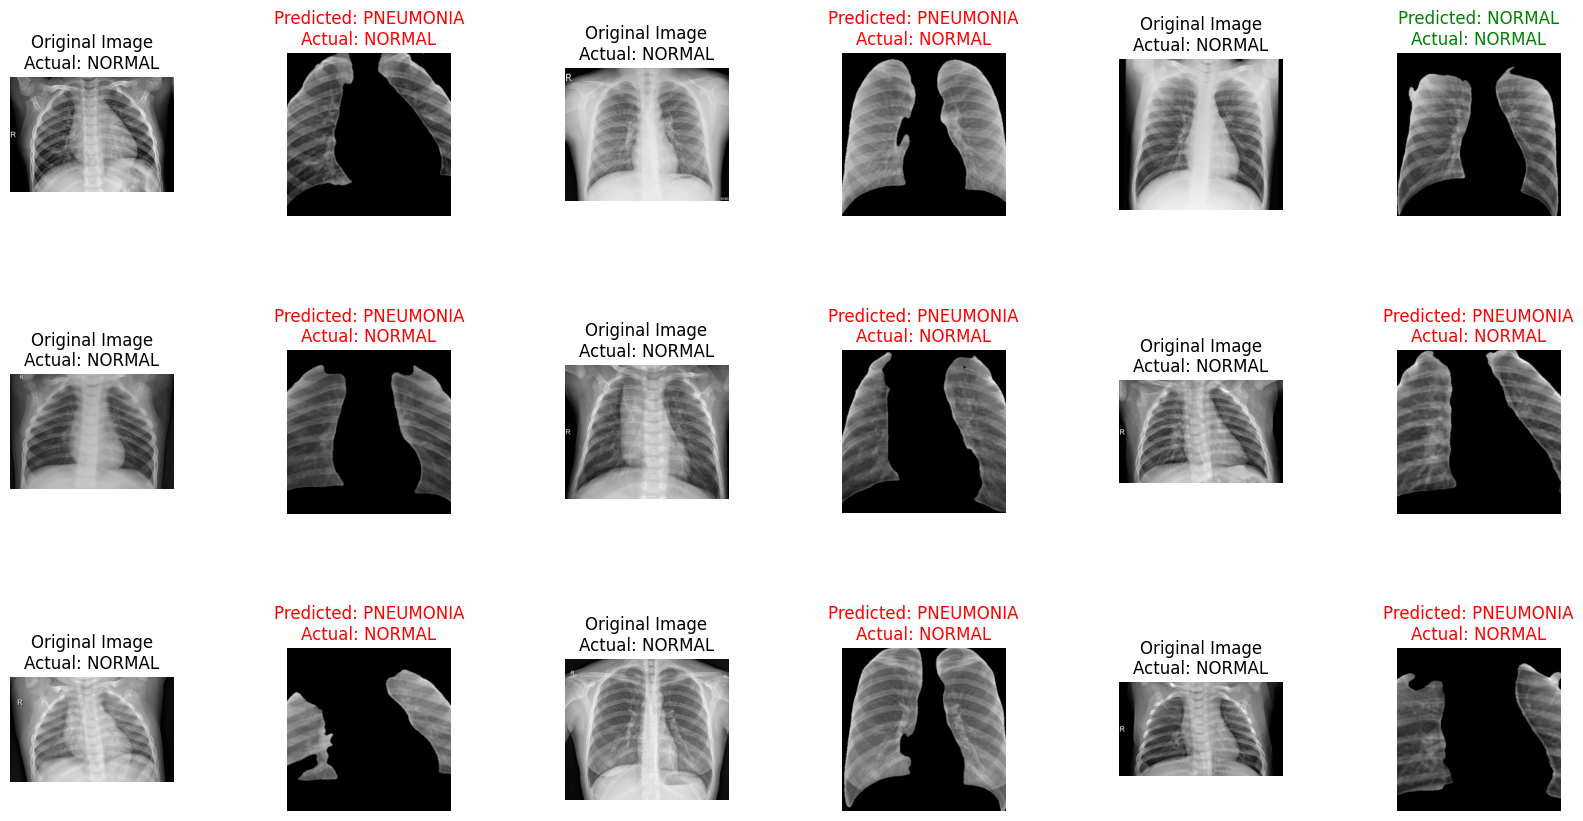

Total Correct: 403.0 
Total Test Images: 624.0
Test Accuracy:  0.6458333333333334


In [7]:
# 필요한 라이브러리 임포트
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import torch
import torchvision.transforms as transforms
from torchvision import models
from src.models import PretrainedUNet
import torch.nn as nn  # 추가된 부분
from collections import OrderedDict

# CUDA 사용 여부 확인 및 디바이스 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  # Print the device being used

# 진폐증 여부를 판단하는 모델 불러오기
class PneumoniaModel(nn.Module):  # 진폐증 모델의 클래스 정의 (기존 모델 정의에 맞게 수정 필요)
    def __init__(self):
        super(PneumoniaModel, self).__init__()
        self.model = models.vgg16(pretrained=False)
        num_features = self.model.classifier[6].in_features
        self.model.classifier[6] = nn.Linear(num_features, 2)  # 진폐증 여부를 판단하는 이진 분류기이므로 출력 노드를 2로 설정

    def forward(self, x):
        return self.model(x)

model_pre = PneumoniaModel()

# 저장된 모델의 state_dict 불러오기
state_dict = torch.load('models/best_pneumonia_model.pth')

# 저장된 state_dict의 키 이름을 모델의 키 이름에 맞게 수정
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = "model." + k  # 모든 키에 "model." 접두사를 추가
    new_state_dict[name] = v

model_pre.load_state_dict(new_state_dict)
model_pre.to(device)
model_pre.eval()

# 폐 세그멘테이션 모델 불러오기
seg_model = PretrainedUNet(
    in_channels=1,
    out_channels=2, 
    batch_norm=True, 
    upscale_mode="bilinear"
)
seg_model.load_state_dict(torch.load('models/unet-6v.pt'))
seg_model.to(device)
seg_model.eval()

# 폐영역 분리 이미지를 위한 함수
def create_segmented_image(img_path):
    origin = Image.open(img_path).convert("L")
    origin_resized = transforms.functional.resize(origin, (512, 512))
    origin_tensor = transforms.functional.to_tensor(origin_resized) - 0.5
    
    with torch.no_grad():
        origin_tensor = torch.stack([origin_tensor]).to(device)
        out = seg_model(origin_tensor)
        softmax = torch.nn.functional.log_softmax(out, dim=1)
        mask = torch.argmax(softmax, dim=1).squeeze(0).cpu().numpy()

    mask_resized = Image.fromarray((mask * 255).astype(np.uint8)).resize(origin.size, Image.NEAREST)
    segmented_img = Image.composite(origin, Image.new('L', origin.size), mask_resized)
    
    return segmented_img

# 데이터 전처리 및 증강
def data_transforms(phase):
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),  # Convert grayscale image to RGB
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
    return transform

# 클래스 이름 전역 변수로 정의
class_names = ['NORMAL', 'PNEUMONIA']

# 모델 성능 평가 함수
def test_model(test_dir):
    running_correct = 0.0
    running_total = 0.0
    true_labels = []
    pred_labels = []
    input_images = []
    original_images = []
    segmented_images = []

    with torch.no_grad():
        for class_name in class_names:
            class_dir = os.path.join(test_dir, class_name)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                original_img = Image.open(img_path).convert("L")
                segmented_img = create_segmented_image(img_path)

                inputs = data_transforms('test')(segmented_img).unsqueeze(0).to(device)
                label = class_names.index(class_name)
                label = torch.tensor([label]).to(device)

                true_labels.append(label.item())
                original_images.append(original_img)
                segmented_images.append(segmented_img)
                input_images.append(inputs)

                outputs = model_pre(inputs)
                _, preds = torch.max(outputs.data, 1)
                pred_labels.append(preds.item())
                running_total += label.size(0)
                running_correct += (preds == label).sum().item()

        acc = running_correct / running_total

    return true_labels, pred_labels, input_images, original_images, segmented_images, running_correct, running_total, acc

# 테스트 데이터셋 경로 설정
test_dir = "input/chest_xray/test"

# 테스트 단계 실행
true_labels, pred_labels, input_images, original_images, segmented_images, running_correct, running_total, acc = test_model(test_dir)

# 결과 시각화
fig, axes = plt.subplots(3, 6, figsize=(20, 10))
fig.subplots_adjust(hspace=0.7, wspace=0.7)
x = 0
for i in range(3):
    for j in range(3):
        if x >= len(original_images):
            break
        # 원본 이미지
        axes[i, j * 2].imshow(original_images[x], cmap='gray')
        axes[i, j * 2].set_title(f"Original Image\nActual: {class_names[true_labels[x]]}")
        axes[i, j * 2].axis('off')
        
        # 분리된 이미지
        segmented_img = segmented_images[x]
        inp = input_images[x].squeeze()
        inp = inp.cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        axes[i, j * 2 + 1].imshow(inp)
        title = f"Predicted: {class_names[pred_labels[x]]}\nActual: {class_names[true_labels[x]]}"
        color = 'green' if pred_labels[x] == true_labels[x] else 'red'
        axes[i, j * 2 + 1].set_title(title, color=color)
        axes[i, j * 2 + 1].axis('off')
        
        x += 1

plt.show()
print("Total Correct: {} \nTotal Test Images: {}".format(running_correct, running_total))
print("Test Accuracy: ", acc)
